## Import libraries

In [64]:
#For dataset
from keras.datasets import mnist

import numpy as np

# Sci Kit Learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
#for parameter checks
import time
# for visualisation
import matplotlib.pyplot as plt
%matplotlib inline


## Load The MNIST Dataset

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

## Show some examples of the data

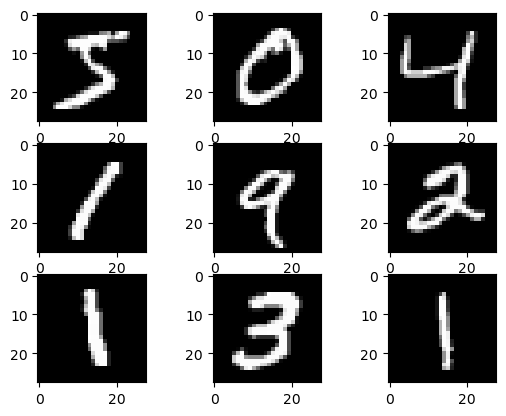

In [3]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))

## Check shapes of data

In [4]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


## To fit this model we need to reshape the data. As clf.fit(...) is going to want a 2d array not 3d.

In [5]:
nsamples, nx, ny = train_X.shape
d2_X = train_X.reshape((nsamples,nx*ny))

In [6]:
d2_X.shape

(60000, 784)

In [7]:
#test data also.
nsamples, nx, ny = test_X.shape
d2_X_test = test_X.reshape((nsamples,nx*ny))

## Split the data into a training, development and test set.
Explain the purpose of each set: The training set will be used to train our model, and is the biggest set of data by far, more than the other two sets combined. The test set will be used as an initial check to see how well the model is finding the correct outcome. The development set will be used after tweaking the parameters of the model based off of the test data accuracy scores.

In [8]:
#since we already split into test and train as we loaded the data, we will now split training into two groups train and development.
X_train, X_development, y_train, y_development = train_test_split(d2_X, train_y, test_size = 0.1, random_state = 42)

## Use the random forest classifier built into sklearn. Pick one parameter to tune and explain why you chose to use this one.

I am going to focus on the n_estimators parameter. This is because, in general, the higher the n_estimators value, the better results the model gets. I want to find the optimal n_estimators value that maximizes accuracy without increasing time. 

In [9]:
clf = RandomForestClassifier()

In [10]:
estimators = range(1,50)
development_scores = []
training_scores = []
time_scores = []
for n in estimators:
    start_time = time.time()
    clf = RandomForestClassifier(n_estimators = n)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    development_score = clf.score(X_development, y_development)
    development_scores.append(development_score)
    training_scores.append(train_score)
    end_time = time.time()
    time_scores.append(end_time - start_time)

Text(0, 0.5, 'Time taken')

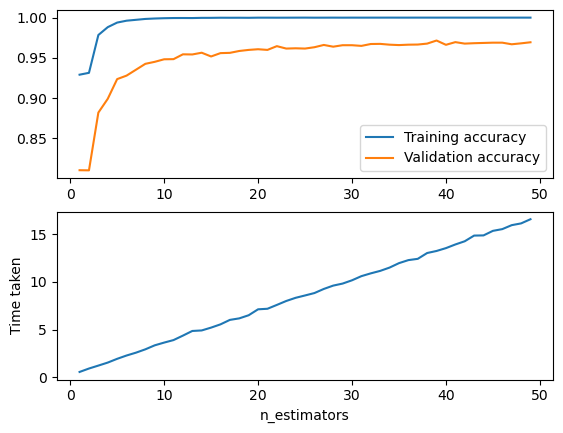

In [25]:
fig, axs = plt.subplots(2)
axs[0].plot(estimators, training_scores, label = "Training accuracy")
axs[0].plot(estimators, development_scores, label = "Validation accuracy")
axs[0].legend()
axs[1].plot(estimators, time_scores, label = "Time taken")
axs[1].set_xlabel("n_estimators")
axs[1].set_ylabel("Time taken")

Using this graph, it shows accuracy does not substantially increase after n_estimators > 20 for the validation set and n = 10 for the training set. Additionally, looking at the graph of the execution time of each iteration, there's a linear increase in time with an increase in estimators. As such it seems most reasonable to use n_estimators = 20 for the test set.

In [19]:
tweaked_clf = RandomForestClassifier(n_estimators = 20)
model = tweaked_clf.fit(X_train, y_train)

predictions = model.predict(d2_X_test)

In [68]:
matrix = confusion_matrix(test_y, predictions)

print(matrix)
print("Score on test model: ", model.score(d2_X_test, test_y))

[[ 971    0    0    2    0    1    1    1    3    1]
 [   0 1120    1    5    2    1    2    1    3    0]
 [   7    1  986    8    5    2    5   13    4    1]
 [   1    0   13  964    0   11    0    9   10    2]
 [   1    0    4    0  947    0    7    1    4   18]
 [   4    1    3   20    1  845    9    1    4    4]
 [   6    4    1    0    7    8  930    0    2    0]
 [   3    4   26    5    7    1    0  970    4    8]
 [   4    0    3   11    9   12    2    0  921   12]
 [   3    4    4   11   20    6    3    7    5  946]]
Score on test model:  0.96


Now to calculate which class [0-9] the model had the most trouble identifing. To do this, the total false negatives and postivies will be summed and subtracted from the total number of 

In [26]:
#vertical is false positive horizontal is false negative
false_negatives = [[] for _ in range(0,10)]
false_positives =[[] for _ in range(0,10)]
correct = []
for m in range(0,10):
    #cycle through pos/neg arrays to assign each class it's false pos/neg
    for n in range(0,10):
        #false negative for m = 0 will be matrix[m = 0] 
        #false positive for m = 0 will be matrix [n][m]
        false_negatives[m]= matrix[m]
        false_positives[m].append(matrix[n][m])
    correct.append(false_negatives[m].tolist().pop(m))
'''
    total_incorrect  = sum of false_positives_m - false_positives_m[m] - (false_negatives_m - false_negatives_m[m]
    
'''
incorrect = [0 for i in range(0,10)]
for n in range(0,10):
        for m in range(0,10):
            if correct[n] != false_negatives[n][m]:
                incorrect[n] += false_negatives[n][m]

In [109]:
difficulty = [0 for _ in range(0,10)]
for n in range(0,10):
    difficulty[n]= incorrect[n] / (correct[n] + incorrect[n])
    
print(f"The class which has the lower accuracy is #{np.argmax(difficulty)}. Only {(100 - difficulty[np.argmax(difficulty)]*100):.2f}% of values were predicted correctly.")

The class which has the lower accuracy is #9. Only 93.76% of values were predicted correctly.


## Calculate the Accuracy, Precision, Recall and F1-score.

In [110]:
FN = [0 for _ in range(0,10)]
FP = [0 for _ in range(0,10)]
TP = [0 for _ in range(0,10)]
TN = [0 for _ in range(0,10)]
for n in range(0,10):
    for m in range(0,10):
        if n == m:
            FN[n] = sum(np.delete(false_negatives[n],n,0))
            FP[n] = sum(np.delete(false_positives[n],n,0))
            TP[n] = matrix[n][m]
            TN[n] = len(test_y) - TP[n]

In [93]:
print("TP: ", TP)
print("\nFP: ", FP)
print("\nTN: ", TN)
print("\nFN: ", FN)

TP:  [971, 1120, 986, 964, 947, 845, 930, 970, 921, 946]

FP:  [29, 14, 55, 62, 51, 42, 29, 33, 39, 46]

TN:  [9029, 8880, 9014, 9036, 9053, 9155, 9070, 9030, 9079, 9054]

FN:  [9, 15, 46, 46, 35, 47, 28, 58, 53, 63]


In [94]:
#Accuracy = TP + TN / TP + FP + TN + FN
#Precision = TP / Tp + Fp
#recall = Tp / TP + FN
#f1 = (2 * precision * recall) / (precision + recall)
accuracy = [0 for _ in range(0,10)]
precision = [0 for _ in range(0,10)]
recall = [0 for _ in range(0,10)]
f1 = [0 for _ in range(0,10)]

for n in range(0, 10):
    accuracy[n] = (TP[n] + TN[n]) / (TP[n] + TN[n] + FN[n] + FP[n])
    precision[n] = TP[n] / (TP[n] + TN[n])
    recall[n] = TP[n] / TP[n] + FN[n]
    f1[n] = 2 * (precision[n] * recall[n]) / (precision[n] + recall[n])
   # print(f"Accuracy for class {n} is: {accuracy[n]:.2f}.")




In [107]:
print("Random Forest Classifier on MNIST data set.")
print("-------------------------------------------")
print("Test data score: ", model.score(d2_X_test, test_y), "\n")
print("Confusion Matrix: \n")
print(matrix)
print("\n")
for n in range(0,10):
    print(f"For Class [{n}]: \n Accuracy: {accuracy[n]:.2f}\n Precision: {precision[n]:.2f}\n Recall: {recall[n]:.2f}\n F1-score: {f1[n]:.2f}\n")

Random Forest Classifier on MNIST data set.
-------------------------------------------
Test data score:  0.96 

Confusion Matrix: 

[[ 971    0    0    2    0    1    1    1    3    1]
 [   0 1120    1    5    2    1    2    1    3    0]
 [   7    1  986    8    5    2    5   13    4    1]
 [   1    0   13  964    0   11    0    9   10    2]
 [   1    0    4    0  947    0    7    1    4   18]
 [   4    1    3   20    1  845    9    1    4    4]
 [   6    4    1    0    7    8  930    0    2    0]
 [   3    4   26    5    7    1    0  970    4    8]
 [   4    0    3   11    9   12    2    0  921   12]
 [   3    4    4   11   20    6    3    7    5  946]]


For Class [0]: 
 Accuracy: 1.00
 Precision: 0.10
 Recall: 10.00
 F1-score: 0.19

For Class [1]: 
 Accuracy: 1.00
 Precision: 0.11
 Recall: 16.00
 F1-score: 0.22

For Class [2]: 
 Accuracy: 0.99
 Precision: 0.10
 Recall: 47.00
 F1-score: 0.20

For Class [3]: 
 Accuracy: 0.99
 Precision: 0.10
 Recall: 47.00
 F1-score: 0.19

For Class 